<a href="https://colab.research.google.com/github/read-project/machine-learning-models/blob/main/Images_vs_Draws%20/Images_Draw_Classif_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Images-Draw Classifier

## Common Setup

In [ ]:
#!pip install imgaug
!pip install git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-a1k7__0p
  Running command git clone --filter=blob:none --quiet https://github.com/aleju/imgaug.git /tmp/pip-req-build-a1k7__0p
  Resolved https://github.com/aleju/imgaug.git to commit 0101108d4fed06bc5056c4a03e2bcb0216dac326
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install keras-tuner -q

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
import pathlib
from matplotlib import pyplot as plt

from tensorflow.keras.applications import ResNet50, VGG16

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from collections import Counter
import imgaug as ia
import imgaug.augmenters as iaa
import imageio
import keras_tuner as kt
from keras.utils.vis_utils import plot_model
import gc
from pathlib import Path
import imghdr
import glob
from multiprocessing import Pool
from PIL import Image

In [ ]:
!pip list | grep tensorflow

tensorflow                       2.12.0
tensorflow-datasets              4.9.2
tensorflow-estimator             2.12.0
tensorflow-gcs-config            2.12.0
tensorflow-hub                   0.13.0
tensorflow-io-gcs-filesystem     0.32.0
tensorflow-metadata              1.13.1
tensorflow-probability           0.20.1


In [ ]:
#tf.compat.v1.enable_eager_execution()

In [ ]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
layers = 3
#n_classes= 5

In [ ]:
def decode_img_pred(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path_pred(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img_pred(img)
  return img

In [ ]:
#Metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Def Model to tune
[Doc keras tuner](https://towardsdatascience.com/hyperparameter-tuning-with-kerastuner-and-tensorflow-c4a4d690b31a)

In [ ]:
def create_model(pretrain_mod='res',
                 pretrain_trainable= False,
                 units= 512,
                 num_layers= 3,
                 activation= 'relu',
                 dropout=[0.1,0.1],
                 global_pooling= 'max',
                 learning_rate = 1e-3,
                 opt_type= 'Adam'
                 ):
  # Initialize the Pretrained Model
  if pretrain_mod== 'res':
    feature_extractor = ResNet50(weights='imagenet',
                                input_shape=(224, 224, 3),
                                include_top=False)
  else:
    feature_extractor = VGG16(weights='imagenet',
                                input_shape=(224, 224, 3),
                                include_top=False)

  # Set this parameter to make sure it's not being trained
  feature_extractor.trainable = pretrain_trainable

  # Set the input layer
  input_ = tf.keras.Input(shape=(224, 224, 3))

  # Rescaling
  x = tf.keras.layers.Rescaling(1./255) (input_)

  # Set the feature extractor layer
  x = feature_extractor(x , training=pretrain_trainable)

  # Set the pooling layer
  if global_pooling == 'max':
    x = tf.keras.layers.GlobalMaxPooling2D(name= 'feature')(x)
  elif global_pooling == 'avg':
    x = tf.keras.layers.GlobalAveragePooling2D(name= 'feature')(x)
  else:
    #Flat layers
    x = tf.keras.layers.Flatten(name= 'feature')(x)

  # Tune the number of hidden layers and units in each.
  # Number of hidden layers: 1 - 5
  # Number of Units: 64 - 512 with stepsize of 32

  for i in range(1, num_layers):
    u_val =units // i
    x= tf.keras.layers.Dense(units=u_val,
                             activation= activation,
                             trainable= not(pretrain_trainable))(x)
    # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
    x= tf.keras.layers.Dropout(dropout[i-1]) (x)



  # Set the final layer with sigmoid activation function
  output_ = tf.keras.layers.Dense(1, activation='sigmoid', trainable= not(pretrain_trainable))(x)

  # Create the new model object
  model = tf.keras.Model(input_, output_)

  if opt_type =='Adam':
    opt=tf.keras.optimizers.legacy.Adam(learning_rate= learning_rate)   #tf.keras.optimizers.Adam(learning_rate= learning_rate)
  elif opt_type =='SGD':
    opt=tf.keras.optimizers.SGD(learning_rate= learning_rate)

  # Compile it
  model.compile(optimizer= opt,
                loss='binary_crossentropy',
                metrics=['accuracy',f1_m])

  return model

# Predict


In [ ]:
#Copy model from Drive
!cp -r '/content/gdrive/MyDrive/Colab Notebooks/ReAD/01_Photo_Draw/model' ./

In [ ]:
# Create a new model instance
model = create_model(
    pretrain_mod= 'vgg',
    #pretrain_trainable=True,
    units= 768,
    activation= 'relu',
    num_layers= 3,
    global_pooling= 'flt',
    #learning_rate= 1e-07,
    opt_type= 'Adam',
    dropout= [0.2,0.2,0.2,0.2,0.2]
    )

# Restore the weights
model.load_weights('./model/only_weights')

In [ ]:
#Copy data from Drive
!cp -r '/content/gdrive/MyDrive/Colab Notebooks/ReAD/01_Photo_Draw/Real_Test_Img' ./

In [ ]:
data_dir=pathlib.Path('Real_Test_Img')
print('Found',len(list(data_dir.glob('*.jpeg'))),'images.')

Found 29 images.


In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*.jpeg'), shuffle=False)

In [ ]:
img_height = 224
img_width = 224
layers = 3
AUTOTUNE = tf.data.AUTOTUNE
class_names=['00_Photo', '01_Draw']

In [ ]:
test_ds = list_ds.map(process_path_pred, num_parallel_calls=AUTOTUNE)

1/1 [==============================] - 0s 156ms/step


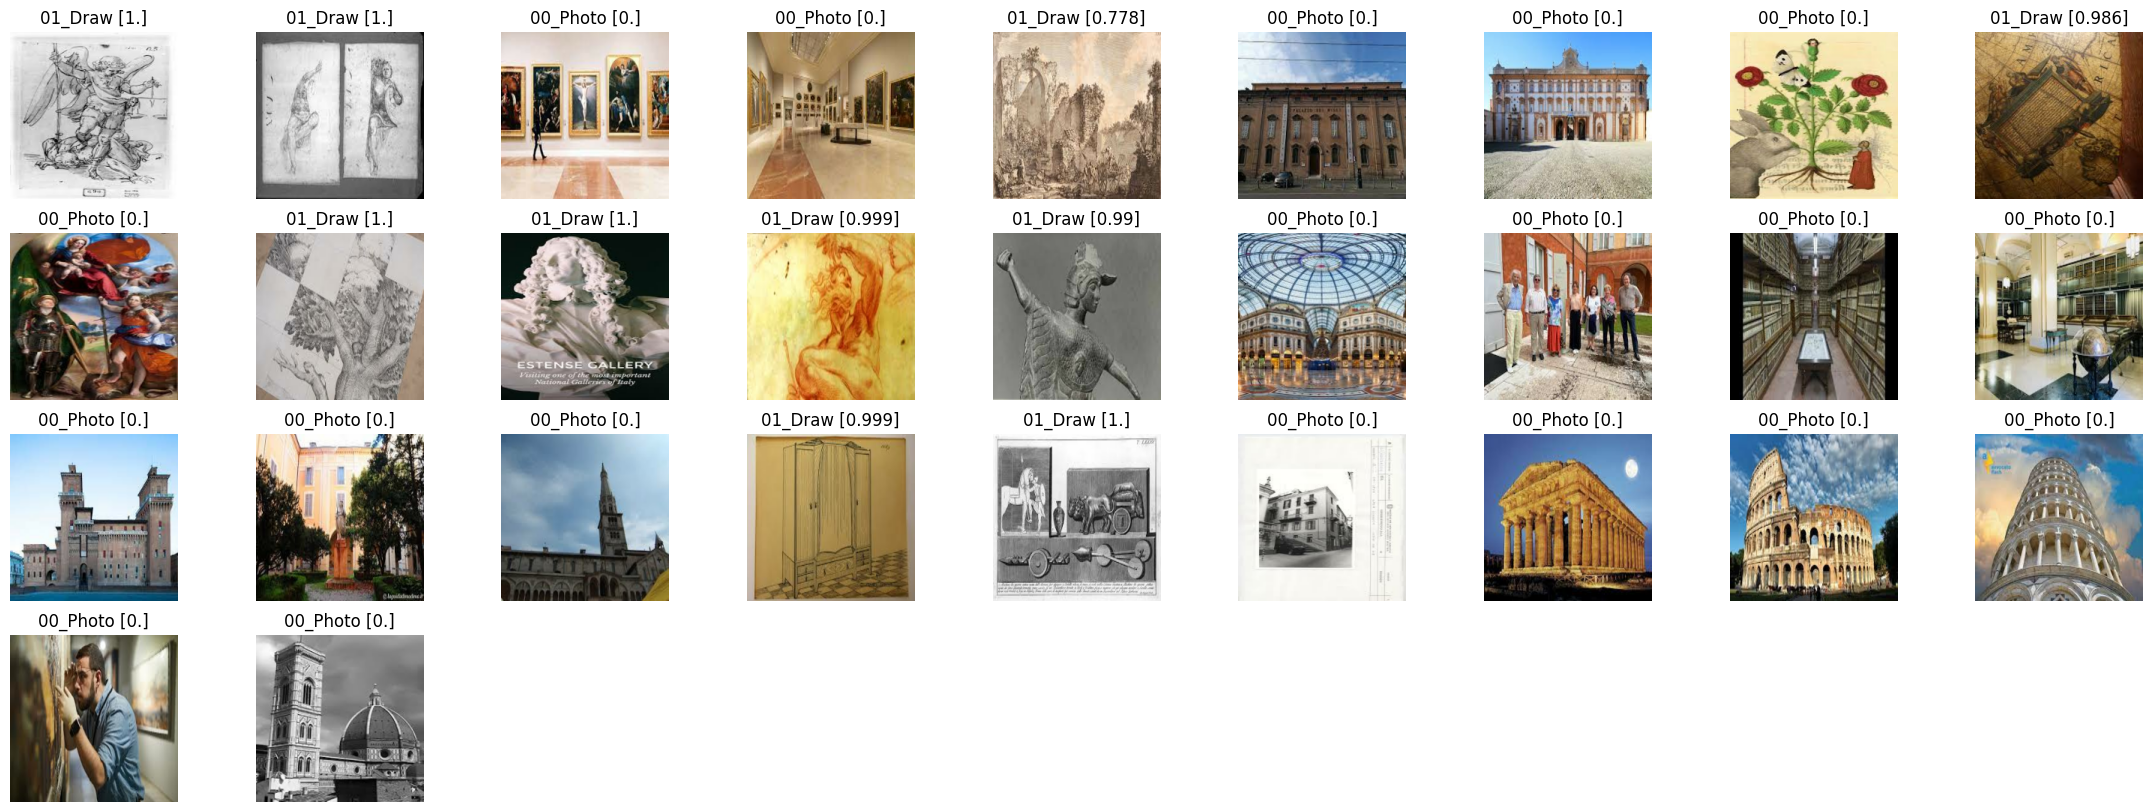

In [ ]:
from time import perf_counter
fig = plt.figure(figsize=(28, 10))
columns = 9
rows = 4

# ax enables access to manipulate each of subplots
ax = []

#Run over all test set and display
pred_labels=[]
i=0
for image in test_ds:
  perc = model.predict(np.expand_dims(image, axis=0))
  y_pred= np.round(perc).astype(int)[0][0]

  img= image.numpy().astype("uint8")

  ax.append( fig.add_subplot(rows, columns, i+1) )
  ax[-1].set_title(class_names[y_pred]+' '+str(np.round(perc,3)[0]))  # set title
  ax[-1].axis("off")

  plt.imshow(img)

  pred_labels.append(y_pred)
  i+=1

plt.show()
